ISOCRONAS PARA EL ANÁLISIS DE COBERTURA DE ESPACIO PÚBLICO

In [2]:
#IMPORTAR LAS LIBRERIAS NECESARIAS
import geopandas as gpd  # Trabaja con datos espaciales como shapefiles y geometrías
from shapely.geometry import Point, LineString, Polygon  # Manejo de objetos geométricos (puntos, líneas, polígonos)
import networkx as nx  # Manejo de grafos
import osmnx as ox# Herramienta para descargar y analizar redes de calles desde OpenStreetMap
import matplotlib.pyplot as plt  # Para graficar
from descartes import PolygonPatch  # Para visualizar polígonos en matplotlib
from IPython.display import IFrame  # Permite mostrar archivos HTML en Jupyter
ox.settings.log_console = True  # Configura osmnx para mostrar logs en la consola
ox.settings.use_cache = True  # Configura osmnx para usar caché
#ox.settings(log_console=True, use_cache=True)  # Configura osmnx para mostrar logs y usar caché


In [3]:
ox.__version__  # Muestra la versión de osmnx

'2.0.3'

In [23]:
# Función para crear un grafo desde una dirección o coordenadas
def create_graph(loc, dist, transport_mode, loc_type="address"):
    # Modo de transporte = ‘walk’, ‘bike’, ‘drive’, etc.
    if loc_type == "address":
        G = ox.graph.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph.graph_from_point(loc, dist=dist, network_type=transport_mode)
    return G

**Isocronas (tiempo de viaje)**

In [4]:
# Bounding box como tupla: (north, south, east, west)
bbox = (19.470186, 19.393667, -99.174962, -99.124310)

# Crear el grafo con la nueva sintaxis
G = ox.graph.graph_from_bbox(
    bbox=bbox,
    network_type='walk',
    simplify=True,
    retain_all=False,
    truncate_by_edge=False,
    custom_filter=None)


# Crear un grafo de la Ciudad de México con un radio de 10 km (10,000 metros)
# G = ox.graph_from_address(
#     address="Ciudad de México, México",
#     dist=10000,                    # radio en metros desde el punto central
#     dist_type='bbox',              # tipo de área (puede ser 'bbox' o 'network')
#     network_type='walk',           # tipo de red: 'all', 'walk', 'bike', 'drive', etc.
#     simplify=True,                 # simplifica la geometría (elimina nodos innecesarios)
#     retain_all=False,              # mantiene solo la componente gigante
#     truncate_by_edge=False,        # no recorta por los bordes de las calles
#     custom_filter=None             # puedes definir un filtro Overpass si quieres algo personalizado
# )


# # 2 - Proyectar el grafo a coordenadas UTM
# G_proj = ox.project_graph(G)

# # 3 - Convertir el punto de interés a UTM (usando el CRS del grafo proyectado)
# point_latlon = Point(-99.133352, 19.432257)  # lon, lat
# gdf_point = gpd.GeoDataFrame(geometry=[point_latlon], crs="EPSG:4326")
# gdf_point_proj = gdf_point.to_crs(G_proj.graph['crs'])
# point_utm = gdf_point_proj.geometry.iloc[0]

# # 4 - Buscar el nodo más cercano en el grafo proyectado
# point_of_interest = ox.distance.nearest_nodes(G_proj, X=point_utm.x, Y=point_utm.y)

# # 5 - Agregar tiempos de viaje (por ejemplo: 5, 10, 15 minutos caminando)
# trip_times = [5, 10, 15]  # minutos
# meters_per_minute = 80  # velocidad caminando (1.33 m/s)
# trip_dists = [t * meters_per_minute for t in trip_times]

# # 6 - Colorear nodos según isocronas
# iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3)
# node_colors = {}

# for trip_time, color in zip(sorted(trip_dists, reverse=True), iso_colors):
#     subgraph = nx.ego_graph(G_proj, point_of_interest, radius=trip_time, distance='length')
#     for node in subgraph.nodes:
#         node_colors[node] = color

# nc = [node_colors.get(node, 'none') for node in G_proj.nodes]
# ns = [20 if node in node_colors else 0 for node in G_proj.nodes]

In [5]:
ox.save_graph_geopackage(G, filepath='G_bbox_.gpkg', encoding='utf-8')

In [10]:
from shapely.geometry import box

# Bounding box: (north, south, east, west)
north = 19.470186
south = 19.393667
east = -99.124310
west = -99.174962

# Crear un polígono shapely
bbox_geom = box(west, south, east, north)

# Crear un GeoDataFrame
gdf_bbox = gpd.GeoDataFrame(geometry=[bbox_geom], crs="EPSG:4326")

# Exportar como archivo GeoPackage
gdf_bbox.to_file("bbox_cdmx.gpkg", layer='bbox', driver="GPKG")

In [23]:
ox.settings.use_cache = False  # desactiva el uso de caché para esta sesión
ox.settings.cache_folder = 'osmnx_cache'  # ubicación de la caché (opcional)

# Para borrar la caché manualmente (si ya existe en disco):
import shutil
shutil.rmtree(ox.settings.cache_folder, ignore_errors=True)

In [51]:
from shapely.geometry import Point
import geopandas as gpd

# Obtener las coordenadas del nodo desde el grafo (lat/lon)
x = G.nodes[point_of_interest]['x']
y = G.nodes[point_of_interest]['y']

# Crear un GeoDataFrame con esas coordenadas
point_geom = [Point(x, y)]
point_of_interest_A = gpd.GeoDataFrame(geometry=point_geom, crs="EPSG:4326")

In [52]:
geojsonr = point_of_interest_A.to_json()

# Write to file
with open("point_of_interest_A.geojson", "w") as f:
    f.write(geojsonr)

In [53]:
# Tiempo de viaje en minutos
trip_times = [5, 15, 25, 40, 60]

# Velocidad de caminata en km/hora
travel_speed = 4.5

# Agrega un atributo a las aristas del grafo con el tiempo (en minutos) que toma recorrerlas
meters_per_minute = travel_speed * 1000 / 60  # Conversión de km/h a m/minuto
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute  # Tiempo = distancia / velocidad


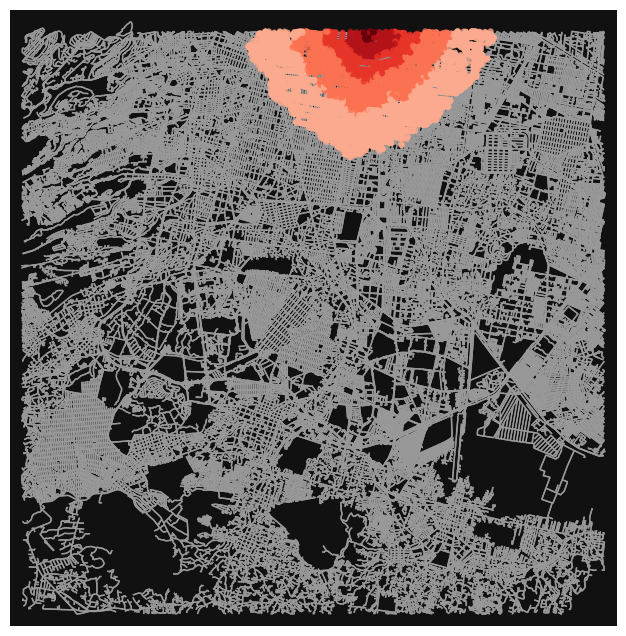

In [54]:
# 1 - Obtiene un color para cada isocrona
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3)
# 2 - Colorea los nodos según la isocrona, luego grafica la red
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
# Define colores y tamaños para los nodos según si están dentro de una isocrona
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot.plot_graph(G, figsize=[8,8], node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)


In [55]:
# Crea polígonos que representan las isocronas (áreas alcanzables en cierto tiempo)
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull  # Convex hull de los puntos
    isochrone_polys.append(bounding_poly)

C:\Users\brenp\AppData\Local\Temp\ipykernel_35556\662695418.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull  # Convex hull de los puntos
C:\Users\brenp\AppData\Local\Temp\ipykernel_35556\662695418.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull  # Convex hull de los puntos
C:\Users\brenp\AppData\Local\Temp\ipykernel_35556\662695418.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull  # Convex hull de los puntos
C:\Users\brenp\AppData\Local\Temp\ipykernel_35556\662695418.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_p

In [ ]:
isocronas = gpd.GeoDataFrame(geometry=isochrone_polys, crs=G.graph['crs'])
print(isocronas.crs)

epsg:4326


In [ ]:
geojson_str = isocronas.to_json()

# Write to file
with open("isochronas.geojson", "w") as f:
    f.write(geojson_str)